# The Wenchuan and Pengguan faults

In this example, we will solve for the surface displacement due to slip on a complex three-dimensional geometry beneath a topographic free surface. 

First, we'll import the necessary tools.

In [42]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse.linalg as spsla

import tectosaur as tct

And the premade mesh that we're going to use:

In [10]:
with open('wenchuan_mesh.pkl', 'rb') as f:
    m = pickle.load(f)

`m` is now a CombinedMesh object which is a handy class for tracking different subsets of a mesh. Let's explore. How many elements are there in this mesh? How about in each of the subsets?

In [133]:
m.n_tris(), m.n_tris('surf'), m.n_tris('fault')

(23742, 23304, 438)

Let's plot up the mesh to get a sense for what we're dealing with!

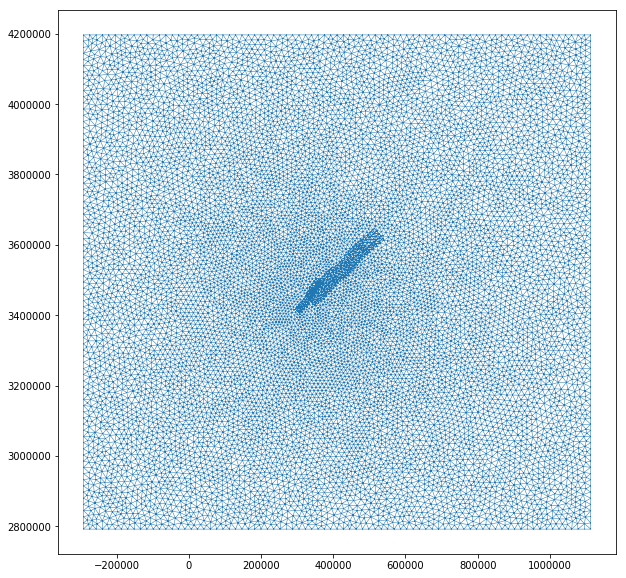

In [132]:
plt.figure(figsize = (10,10))
plt.triplot(m.pts[:,0], m.pts[:,1], m.tris, linewidth = 0.5)
plt.show()

We can see the fault mesh in the center, with the surface elements getting larger further from the fault. Let's zoom in and just look at the fault surface.

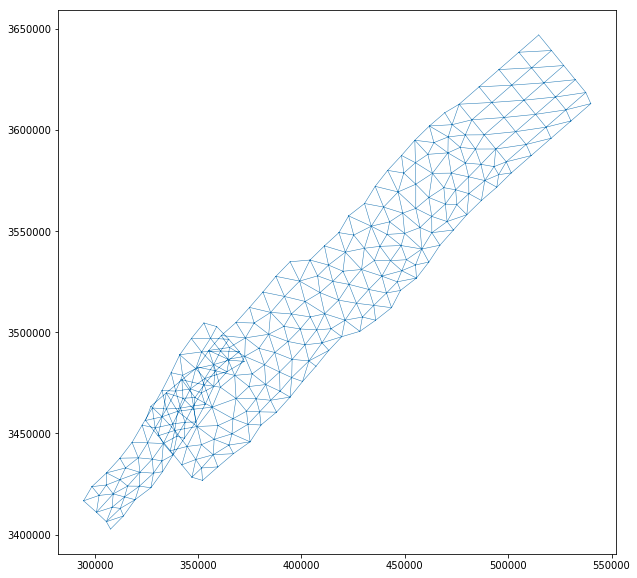

In [13]:
plt.figure(figsize = (10,10))
plt.triplot(m.pts[:,0], m.pts[:,1], m.get_tris('fault'), linewidth = 0.5)
plt.show()

There are two separate fault surfaces. The western surface (on the left) is the Wenchuan fault, while the eastern surface that extends far to the northeast is the Pengguan fault. This fault geometry is based on structural work by Hubbard, Shaw and Klinger (2009).

We were promised topography! Let's check on that. 

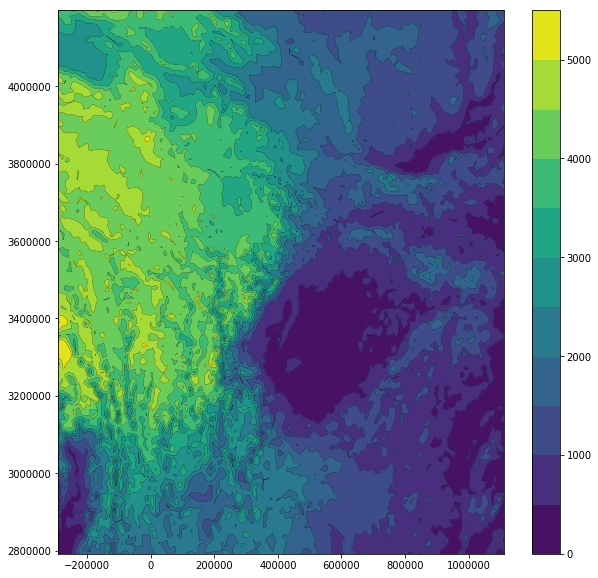

In [14]:
levels = np.linspace(0, 5500, 12)
plt.figure(figsize = (10,10))
cntf = plt.tricontourf(
    m.pts[:,0], m.pts[:,1], m.get_tris('surf'), m.pts[:,2], levels = levels
)
plt.tricontour(
    m.pts[:,0], m.pts[:,1], m.get_tris('surf'), m.pts[:,2], 
    linestyles = 'solid', colors='k', linewidths = 0.25, levels = levels
)
plt.colorbar(cntf)
plt.show()

Fantastic. Next, we'll set up a sample slip field on the fault surface. For simplicity, the slip field will be exclusively thrust motion. To do that, we'll project the vertical vector $(0,0,1)$ into the plane of each triangle.

In [135]:
# First, we get an array of (n_fault_tris, 3, 3) that contains the three
# points for the vertices of each triangle
fault_tri_pts = m.pts[m.get_tris('fault')]

# Then, we compute the normal vector:
fault_normals = np.cross(
    fault_tri_pts[:,2,:] - fault_tri_pts[:,0,:],
    fault_tri_pts[:,2,:] - fault_tri_pts[:,1,:]
)
fault_normals /= np.linalg.norm(fault_normals, axis = 1)[:, np.newaxis]

# Next, we project our slip vector (0, 0, 1) into the plane defined 
# by the triangle normal vectors
v = [0,0,1]
tri_slip = v - fault_normals * (fault_normals.dot(v)[:, np.newaxis])

# Finally, we need a slip value for each degree of freedom. Each triangle
# has a degree of freedom located at each of its vertices. We will simply 
# replicate the slip field so that the slip is the same at all three of a
# triangles vertices.
slip = -np.tile(tri_slip[:,np.newaxis,:], (1,3,1))

Let's plot the x, y and z components of that slip field just to get a sense of it.

/home/tthompson/tools/pyenv/versions/miniconda3-4.3.11/lib/python3.6/site-packages/matplotlib/contour.py:1004: UserWarning: The following kwargs were not used by contour: 'linewidth'
  s)


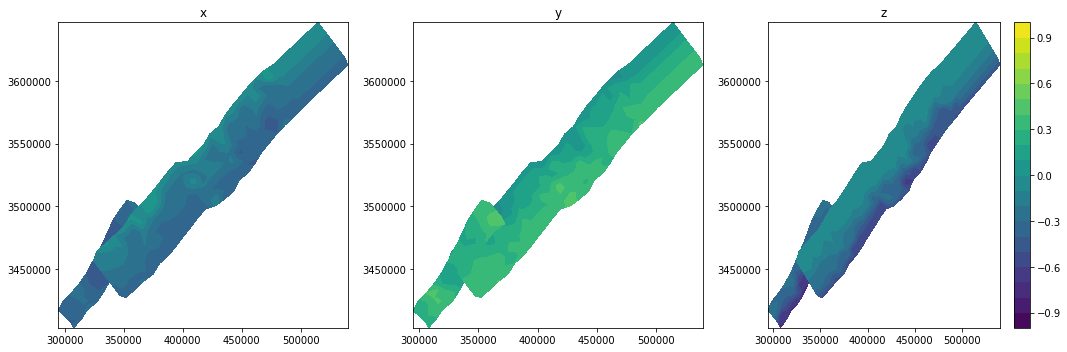

In [139]:
# We need to determine the slip field at each point rather than each degree of freedom!
pt_slip = np.zeros((m.pts.shape[0], 3))
pt_slip[m.get_tris('fault')] = slip.reshape((-1,3,3))

levels = np.linspace(-1, 1, 21)
plt.figure(figsize = (15,5))

for d in range(3):
    plt.subplot(1,3,d + 1)
    plt.title(['x', 'y', 'z'][d])
    plt.tricontourf(m.pts[:,0], m.pts[:,1], m.get_tris('fault'), pt_slip[:, d], linewidth = 0.5, levels = levels)
    plt.xlim([np.min(m.pts[m.get_tris('fault'),0]), np.max(m.pts[m.get_tris('fault'),0])])
    plt.ylim([np.min(m.pts[m.get_tris('fault'),1]), np.max(m.pts[m.get_tris('fault'),1])])
    if d == 2:
        plt.colorbar()
plt.tight_layout()
plt.show()

Next, we'll build the boundary element matrix, `T`, the mass matrix, the constraint matrices and then solve the linear system. This code is almost identical to the code in the Okada example, so I won't explain it in detail. That similarity is one of the powerful aspects of Tectosaur. With almost exactly the same code we can solve a boundary element problem with a small planar fault or a large complex fault geometry including topography. 

In [34]:
sm = 3e10 # Shear modulus
pr = 0.25 # Poisson ratio
T = tct.RegularizedSparseIntegralOp(
    8, # The coincident quadrature order
    8, # The edge adjacent quadrature order
    8, # The vertex adjacent quadrature order
    2, # The farfield quadrature order
    5, # The nearfield quadrature order
    2.5, # The element length factor to separate near from farfield.
    'elasticRT3', # The Green's function to integrate
    'elasticRT3', #...
    [sm, pr], # The material parameters (shear modulus, poisson ratio)
    m.pts, # The mesh points
    m.tris, # The mesh triangles
    np.float32,   # The float type to use. float32 is much faster on most GPUs
    
    # Finally, do we use a direct (dense) farfield operator or do we use the Fast Multipole Method?
    farfield_op_type = tct.TriToTriDirectFarfieldOp 
    #farfield_op_type = FMMFarfieldOp(mac = 4.5, pts_per_cell = 100)
)

In [40]:
mass = tct.MassOp(3, m.pts, m.tris)
lhs = tct.SumOp([T, tct.MultOp(mass, 0.5)])

bc_cs = tct.all_bc_constraints(
    m.n_tris('surf'), # The first triangle index to apply BCs to. The first fault triangle is at index `n_surf_tris`.
    m.n_tris(), # The last triangle index to apply BCs to.
    slip.flatten() # The BC vector should be n_tris * 9 elements long. 
)
continuity_cs = tct.continuity_constraints(
    m.pts, # The mesh points. 
    m.tris, # The mesh triangles
    m.n_tris('surf') # How many surface triangles are there? The triangles are expected to be arranged so that the surface triangles come first. The remaining triangles are assumed to be fault triangles.
)
cs = bc_cs + continuity_cs
cm, c_rhs, _ = tct.build_constraint_matrix(cs, lhs.shape[1])
rhs_constrained = cm.T.dot(-lhs.dot(c_rhs))

[1738058:DEBUG:tectosaur.ops.sparse_integral_op]
    start farfield_dot
[1738371:DEBUG:tectosaur.ops.sparse_integral_op]
     farfield_dot took 0.313107892870903
[1738372:DEBUG:tectosaur.ops.sparse_integral_op]
    start nearfield_dot
[1738907:DEBUG:tectosaur.ops.sparse_integral_op]
     nearfield_dot took 0.5358337052166462


In [43]:
def mv(v, it = [0]):
    it[0] += 1
    print('iteration # ' + str(it[0]))
    return cm.T.dot(lhs.dot(cm.dot(v)))
n = rhs_constrained.shape[0]
A = spsla.LinearOperator((n, n), matvec = mv)
gmres_out = spsla.gmres(
    A, rhs_constrained, tol = 1e-6, restart = 200, 
    callback = lambda R: print('residual: ', str(R))
)
soln = cm.dot(gmres_out[0]) + c_rhs

iteration # 1
[1754260:DEBUG:tectosaur.ops.sparse_integral_op]
    start farfield_dot
[1754571:DEBUG:tectosaur.ops.sparse_integral_op]
     farfield_dot took 0.3111201822757721
[1754572:DEBUG:tectosaur.ops.sparse_integral_op]
    start nearfield_dot
[1754768:DEBUG:tectosaur.ops.sparse_integral_op]
     nearfield_dot took 0.19562465697526932
iteration # 2
[1754773:DEBUG:tectosaur.ops.sparse_integral_op]
    start farfield_dot
[1755084:DEBUG:tectosaur.ops.sparse_integral_op]
     farfield_dot took 0.3101925328373909
[1755084:DEBUG:tectosaur.ops.sparse_integral_op]
    start nearfield_dot
[1755278:DEBUG:tectosaur.ops.sparse_integral_op]
     nearfield_dot took 0.19311532378196716
iteration # 3
[1755318:DEBUG:tectosaur.ops.sparse_integral_op]
    start farfield_dot
[1755628:DEBUG:tectosaur.ops.sparse_integral_op]
     farfield_dot took 0.31036828085780144
[1755629:DEBUG:tectosaur.ops.sparse_integral_op]
    start nearfield_dot
[1755822:DEBUG:tectosaur.ops.sparse_integral_op]
     nearfield

With the solution in hand, let's make a rough plot of each component of the surface displacement field. 

/home/tthompson/tools/pyenv/versions/miniconda3-4.3.11/lib/python3.6/site-packages/matplotlib/contour.py:1004: UserWarning: The following kwargs were not used by contour: 'linewidth'
  s)


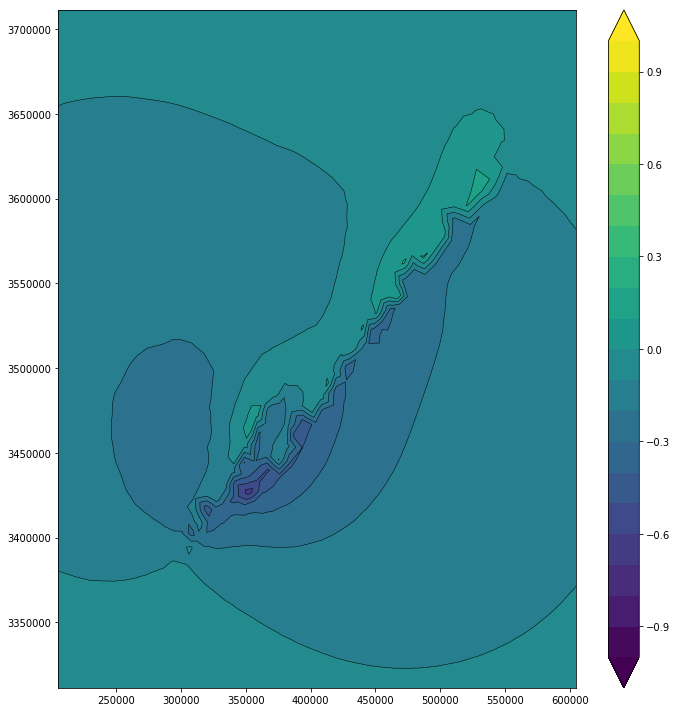

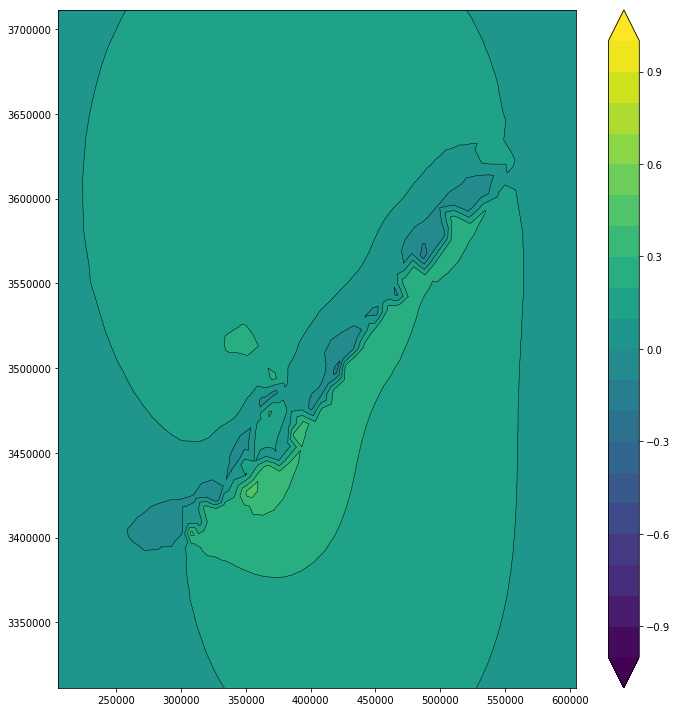

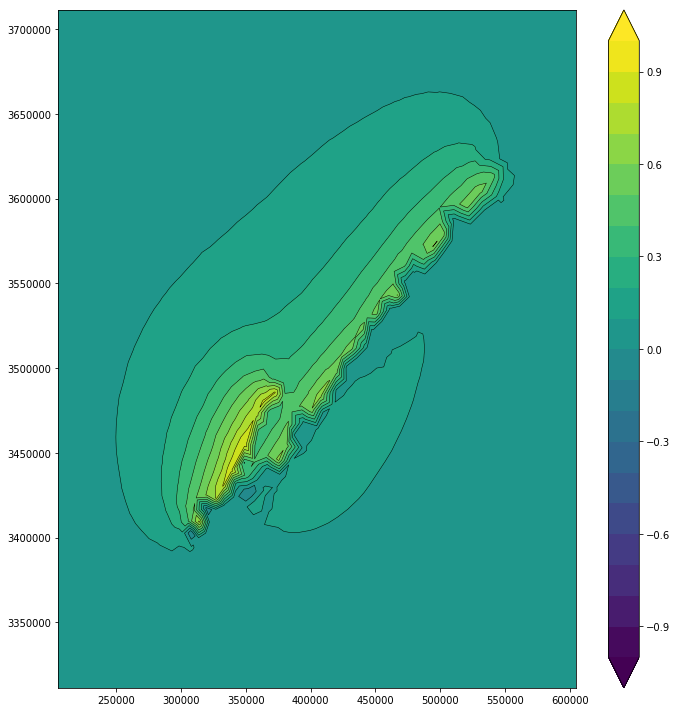

In [100]:
pt_disp = np.zeros((m.pts.shape[0], 3))
pt_disp[m.get_tris('surf')] = m.get_dofs(soln, 'surf').reshape((-1,3,3))
    
view_center = np.mean(m.pts[m.get_tris('fault'),:].reshape((-1,3)), axis = 0)
view_R = 200000
levels = np.linspace(-1, 1, 21)

for d in range(3):
    plt.figure(figsize = (10,10))
    plt.title(['x', 'y', 'z'][d])
    cntf = plt.tricontourf(
        m.pts[:,0], m.pts[:,1], m.get_tris('surf'), pt_disp[:, d], 
        linewidth = 0.5, levels = levels, extend = 'both'
    )
    plt.tricontour(
        m.pts[:,0], m.pts[:,1], m.get_tris('surf'), pt_disp[:, d], 
        linestyles = 'solid', colors='k', linewidths = 0.5, levels = levels
    )
    plt.xlim([view_center[0] - view_R, view_center[0] + view_R])
    plt.ylim([view_center[1] - view_R, view_center[1] + view_R])
    plt.colorbar(cntf)
    plt.tight_layout()
    plt.show()

It's exciting! There's some interesting behavior going on, especially near the fault trace. But, these figures really aren't very interpretable, especially near the fault trace. That's primarily because the `tricontourf` function doesn't handle discontinuity. As a result, it tries the smooth the jump in displacement across the fault. That's why there are several contour lines bunched close together near the fault trace. Let's try to make a better figure. 

There's a trick with the `tricontourf` function. If you exclude the triangles on one side of the fault, you'll get a sharp edge. So, we're going to actually make two `tricontourf` plots. One with the triangles on one side of the fault, and the other with the triangles on the other side of the fault.

First, we need to figure out which surface triangles are on which side of the fault.

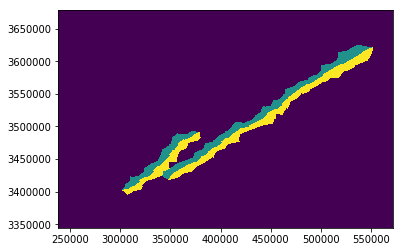

In [147]:
fault_start_idx = m.get_start('fault')
side = tct.continuity.get_side_of_fault(m.pts, m.tris, fault_start_idx)

plt.tripcolor(m.pts[:,0], m.pts[:,1], m.get_tris('surf'), side[:m.n_tris('surf')])
plt.xlim([view_center[0] - view_R / 1.5, view_center[0] + view_R / 1.5])
plt.ylim([view_center[1] - view_R / 1.5, view_center[1] + view_R / 1.5])
plt.show()

Perfect! Most of the mesh is not touching the fault, so it's marked 0. The triangles on the northwestern side are marked 1 and triangles are southeastern side are marked 2. It's also nice to identify the edges in the mesh that form the fault trace: `surf_fault_edges`

In [117]:
surf_verts = np.unique(m.get_tris('surf'))
surf_fault_edges = []
for i, t in enumerate(m.get_tris('fault')):
    in_surf = []
    for d in range(3):
        if t[d] in surf_verts:
            in_surf.append((i, d))
    if len(in_surf) == 2:
        surf_fault_edges.append(in_surf)

Now, let's make that figure!

/home/tthompson/tools/pyenv/versions/miniconda3-4.3.11/lib/python3.6/site-packages/matplotlib/contour.py:1004: UserWarning: The following kwargs were not used by contour: 'linewidth'
  s)


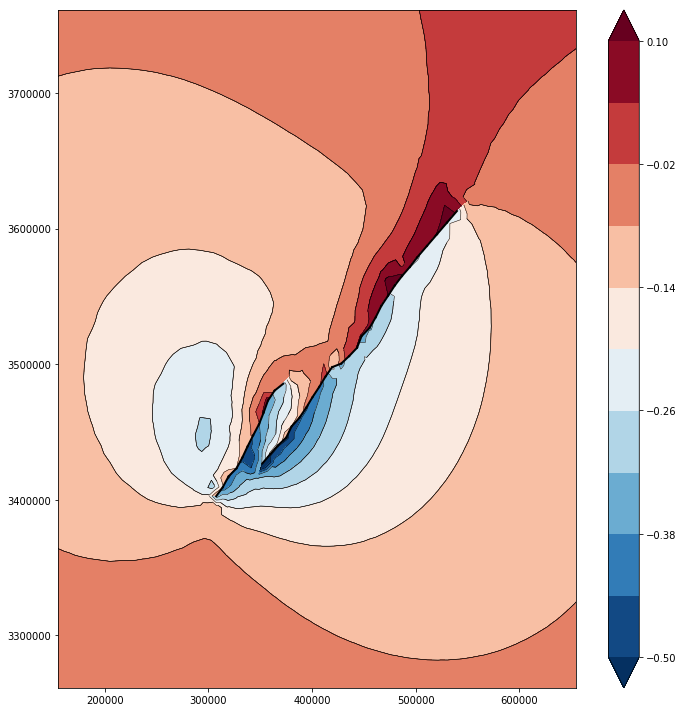

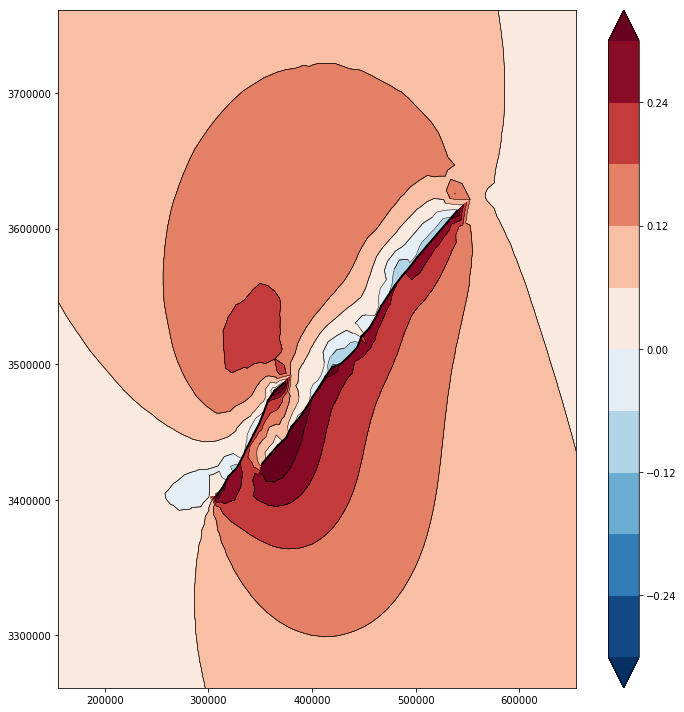

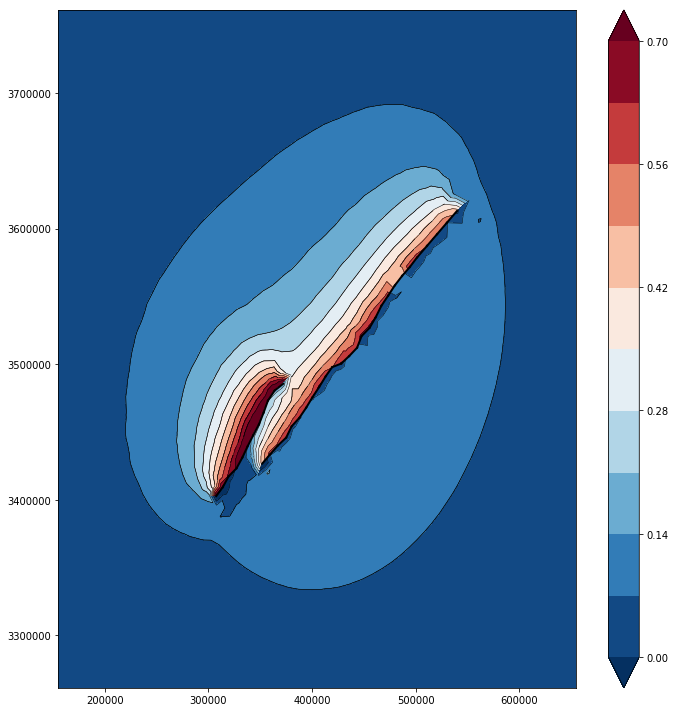

In [149]:
view_center = np.mean(m.pts[m.get_tris('fault'),:].reshape((-1,3)), axis = 0)
view_R = 250000    
cmap = 'RdBu_r'

levels = [
    np.linspace(-0.5, 0.1, 11),
    np.linspace(-0.3, 0.3, 11),
    np.linspace(0, 0.7, 11)
]

for d in range(3):
    
    field = m.get_dofs(soln, 'surf').reshape((-1,3,3))[:,:, d]
    plt.figure(figsize = (10,10))
    
    # This is the critical section of code. We take all the triangles except one of the fault touching 
    # sides and make a contour plot with them. The combination of the two contour plots results in a 
    # nice clean edge.
    for i in range(2):
        which_tris = np.where(np.logical_or(side[:fault_start_idx] == 0, side[:fault_start_idx] == i + 1))[0]
        reduced_m = tct.mesh.modify.remove_unused_pts((m.pts, m.tris[which_tris]))
        soln_vals = np.empty(reduced_m[0].shape[0])
        soln_vals[reduced_m[1]] = field[which_tris]
        
        cntf = plt.tricontourf(
            reduced_m[0][:,0], reduced_m[0][:,1], reduced_m[1], soln_vals, 
            cmap = cmap, linewidth = 0.5, levels = levels[d], extend = 'both'
        )
        plt.tricontour(
            reduced_m[0][:,0], reduced_m[0][:,1], reduced_m[1], soln_vals, 
            linestyles = 'solid', colors='k', linewidths = 0.5, levels = levels[d]
        )
    
    # Here, we plot the fault trace edges.
    fault_tris = m.get_tris('fault')
    for e in surf_fault_edges:
        i1, d1 = e[0]
        i2, d2 = e[1]
        pts = m.pts[[fault_tris[i1,d1], fault_tris[i2,d2]]]
        plt.plot(pts[:,0], pts[:,1], 'k-', linewidth = 2)
        
    plt.xlim([view_center[0] - view_R, view_center[0] + view_R])
    plt.ylim([view_center[1] - view_R, view_center[1] + view_R])
    plt.colorbar(cntf)
    plt.tight_layout()
    plt.show()

That's much much better! 